# Disaster Tweets NLP
a Disaster Tweets Classfier

In [2]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from nltk.stem.snowball import stopwords
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
import keras
import keras_nlp

Using TensorFlow backend


In [3]:
dftrain = pd.read_csv('train.csv')
dftrain

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
dftest = pd.read_csv('test.csv')
dftest

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


# Exploratory Data Analysis

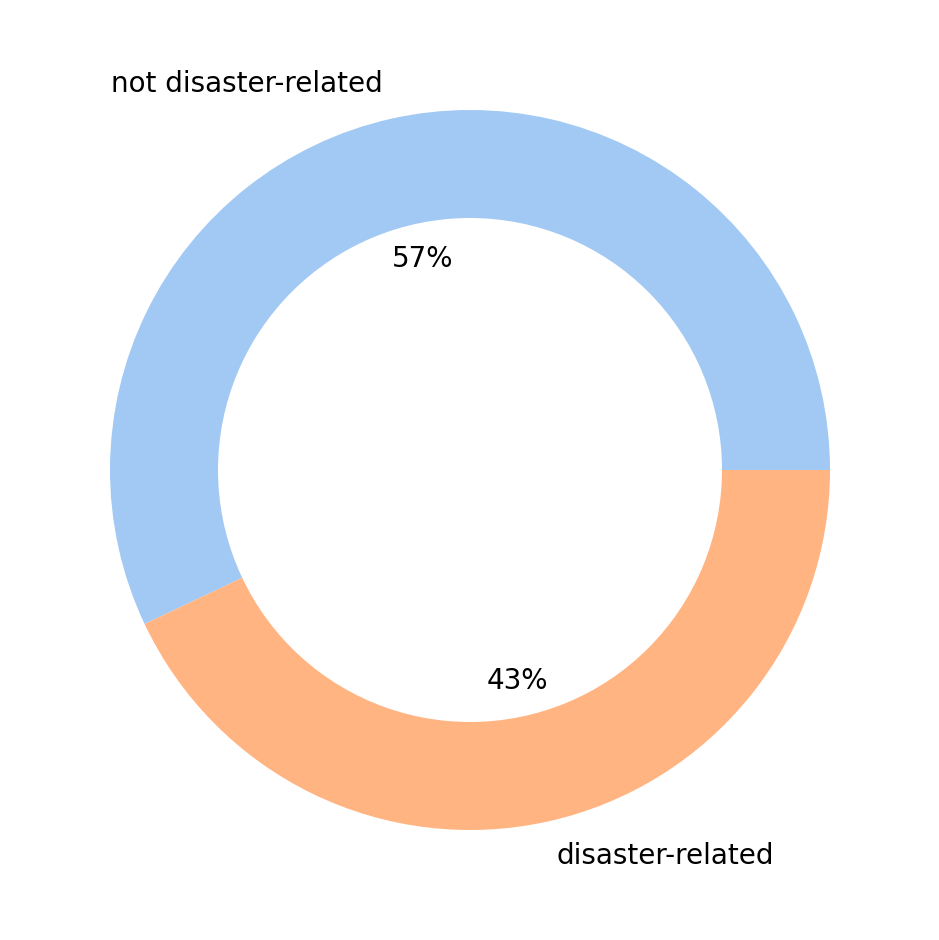

In [13]:
data = dftrain['target'].value_counts()
labels = ['not disaster-related', 'disaster-related']
colors = sns.color_palette('pastel')[0:2]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()

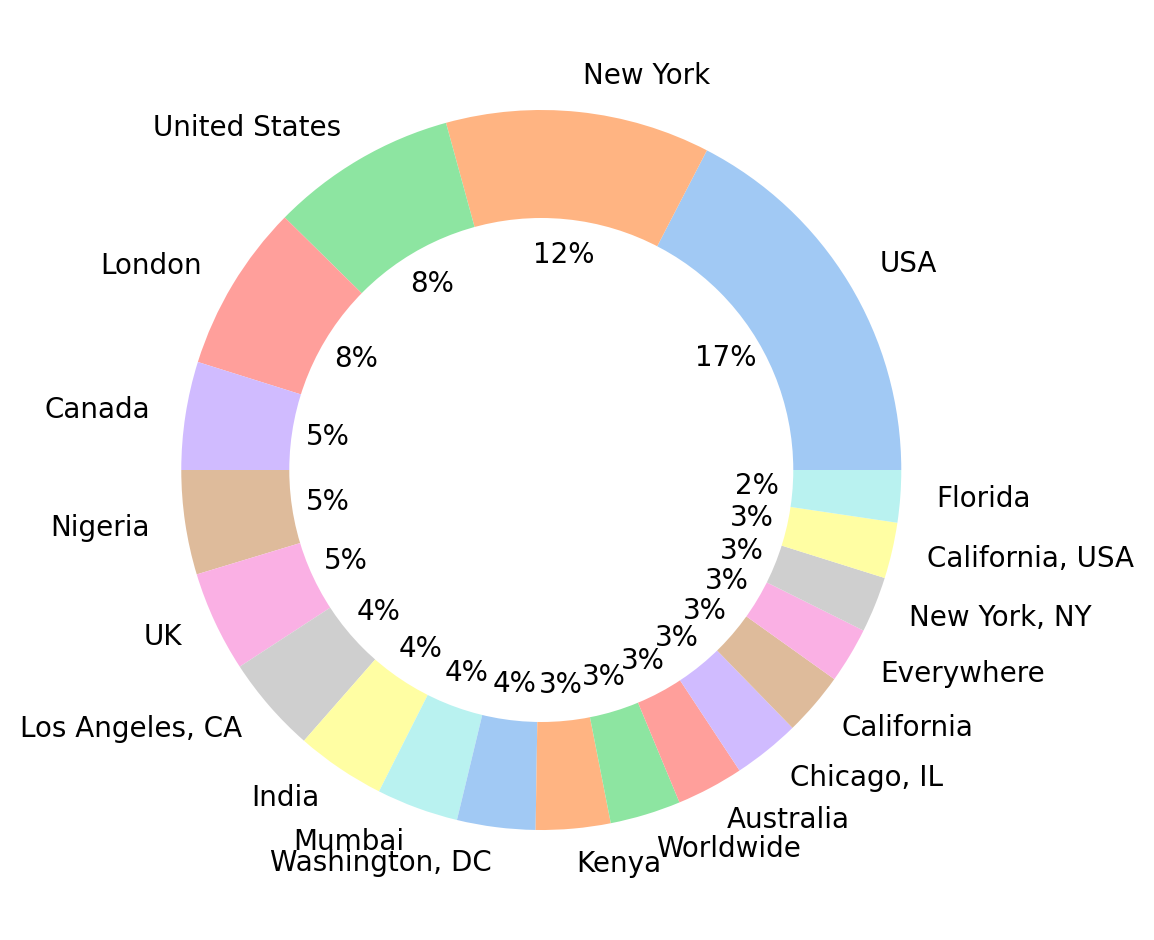

In [18]:
data = dftrain['location'].value_counts()[:20]
labels = dftrain['location'].value_counts()[:20].index
colors = sns.color_palette('pastel')[0:len(data)]
# plt.figure(figsize=(9, 9))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()

# Data Wrangling

In [5]:
punctuation = set(string.punctuation)
stopwordsSet = set(stopwords.words("english"))
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789 '

def clean_text(text):
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('amp', '', text)
    text = ''.join(c for c in text.lower() if c not in punctuation and c in alphabet)
    text = ' '.join(w for w in text.split() if w not in stopwordsSet)
    return text

dftrain.text = dftrain.text.apply(lambda x: clean_text(x))
dftest.text = dftest.text.apply(lambda x: clean_text(x))

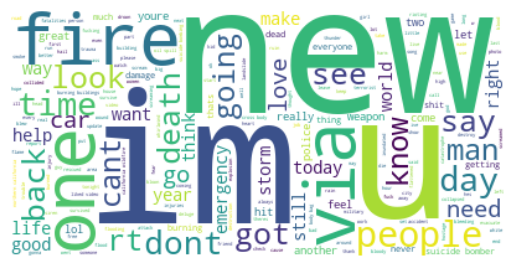

In [6]:
text = " ".join(d for d in dftrain['text'])
wordcloud = WordCloud(background_color='white').generate(text)
# fig = plt.figure(figsize=(15, 30))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

# Feature Engineering

In [11]:
Xtrain = list(dftrain.text)
ytrain = list(dftrain.target)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, stratify=ytrain, random_state=42)
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

### TFIDF
for feature extraction

In [24]:
vectorizer = TfidfVectorizer(max_df=0.4, sublinear_tf=True)

Xtrain = vectorizer.fit_transform(Xtrain)
Xtest = vectorizer.transform(Xtest)

# Model Training

In [18]:
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=40,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer_2 (DistilBertTokenizer)      │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone_2 (DistilBertBackbone)   │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_2 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=Xtrain,
                         y=ytrain,
                         batch_size=32,
                         epochs=2, 
                         validation_data=(Xtest, ytest)
                        )

Epoch 1/2
179/179 [==============================] - 933s 5s/step - loss: 0.5159 - accuracy: 0.7476 - val_loss: 0.4294 - val_accuracy: 0.8162
Epoch 2/2
179/179 [==============================] - 935s 5s/step - loss: 0.3923 - accuracy: 0.8332 - val_loss: 0.4182 - val_accuracy: 0.8272


## Logistic Regression

In [32]:
modlog = LogisticRegression(C=3, solver='saga')
modlog.fit(Xtrain,ytrain)
scores = cross_val_score(modlog, Xtrain, ytrain, scoring='accuracy', cv=skf)
cvlog = scores.mean()
cvlog

0.7889285061955977

In [33]:
pred = modlog.predict(Xtest)
f1log = f1_score(ytest,pred,average='weighted')
acclog = accuracy_score(ytest,pred)
f1log, acclog

(0.8093276573625723, 0.8109243697478992)

In [30]:
submission = pd.read_csv('sample_submission.csv')
test_data = vectorizer.transform(list(dftest.text))
submission.target = modlog.predict(test_data)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [31]:
submission.to_csv("submission.csv", index=False)